# UAMP v.s. DensMAP 
The main goal of this experiment is to demonstrate that the density-preserving dimension reduction method, densMAP affects the shape of the energy landscape. This is in comparison to the original UMAP when using the same latent space output from cryoDRGN.

**We used the default parameters and activated the transition weighting option in all our experiments.**

In [1]:
import numpy as np 
import pandas as pd
import os 
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Use cryodrgn env
from cryodrgn import utils
from cryodrgn import analysis
from cryodrgn import fft, mrc

import umap

In [2]:
def get_nearest_point(data, query):
    '''
    Find closest point in @data to @query
    Return index 
    '''
    ind = cdist(query, data).argmin(axis=1)
    return ind

def free_energy(emb, n_states):
    '''
    Convert to energy landscape based on bins-count appraoch.
    '''
    grids, _ = np.histogramdd(emb, bins=(n_states+1, n_states+1)) # n+1 bins to cut n cells
    grids = grids.T
    # Energy
    occmax = np.amax(grids)
    E = -np.log(grids/occmax)
    E[E==np.inf] = np.unique(E)[-2] + 0.00001 # replace -inf to second lowest energy plus constant.
    return E

def points_for_polaris(emb, n_states, list_idx):
    '''
    Convert the starting and ending point index in to the location in 2D energy landscape.
    '''
    x = emb[:,0][list_idx]
    y = emb[:,1][list_idx]
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states+1)
    n_cells_y = np.linspace(emb[:,1].min(), emb[:,1].max(), n_states+1)
    x = np.digitize(x, n_cells_x) -1
    y = np.digitize(y, n_cells_y) -1
    return np.stack((x,y), axis=1)

def convert_polaris_result(emb, path, n_states=60):
    ''' 
    After searching MEP using POLARIS, convert the path location in 2D back to data point index
    '''
    # Create the bin edges
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states + 1)
    n_cells_y = np.linspace(emb[:,1].min(), emb[:,1].max(), n_states + 1)
    # Calculate the center of each bin
    centers_x = (n_cells_x[:-1] + n_cells_x[1:]) / 2
    centers_y = (n_cells_y[:-1] + n_cells_y[1:]) / 2
    # energy coordiante -> embedding space coordinate
    emb_x = centers_x[path[:, 0].astype(int)]
    emb_y = centers_y[path[:, 1].astype(int)]
    polaris_2d = np.stack((emb_x, emb_y), axis=1)
    # embedding space coordinate -> nearest point index 
    polaris_path = get_nearest_point(emb, polaris_2d)
    return polaris_path

In [3]:

##### MOTIFY THIS PART WHILE DOING OTHER EXPERIMENTS #####
def cal_state_label(x, y):
    '''calculate ground truth labels'''
    label = 20*(x-1)+y
    return label

def get_ground_truth_labels(occ, n_PDs):
    '''
    Calculate ground truth label for each center.
    Since when we create MRC clones are use the order of occ[i][j], 
    the ground truth label would start at CM2 firest. 
    e.g. state_01_01 -> state_01_02 -> ... -> state_05_05 clone 5 times -> ...
    And each MRC would have N PDs images 
    '''
    n_confs = occ.shape[0]**2 # 20x20 CMs in hsp90 experiment
    occ_list = occ.T.flatten().astype(int) # equivalent to occ[i][j]
    ground_truth_labels = np.repeat(np.repeat(np.arange(1,n_confs+1), occ_list), n_PDs)
    return ground_truth_labels

def get_centers_and_path(z, ground_truth_labels):
    '''
    In hsp90 experiment, state1:(5,5), state2(15,16), transition:(15,5)
    '''
    state1 = ground_truth_labels==cal_state_label(5,5)
    state2 = ground_truth_labels==cal_state_label(15,16)
    transition_state = ground_truth_labels==cal_state_label(15,5)

    center1 = get_nearest_point(z, [np.mean(z[state1], axis=0)])[0]
    center2 = get_nearest_point(z, [np.mean(z[state2], axis=0)])[0]
    transition = get_nearest_point(z, [np.mean(z[transition_state], axis=0)])[0]

    path1_label = cal_state_label(np.arange(5,16), 5)
    path1 = []
    for i in path1_label:
        path1.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    path2_label = cal_state_label(15, np.arange(5,16+1))
    path2 = []
    for i in path2_label:
        path2.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    truth_path = path1 + path2

    return state1, state2, transition_state, center1, center2, transition, truth_path
#######################################################

In [7]:
# load ground trouth occupancy map
occ = np.load("/mnt/d/energy_aware_pathfinding/hsp90/noise_occ_1120.npy")
# load training outputs
z = utils.load_pkl("/mnt/d/energy_aware_pathfinding/hsp90//z_8/z.49.pkl")

workdir = "/mnt/d/energy_aware_pathfinding/supplementary/UMAP_vs_densMAP"

# get lables
n_PDs = 50
ground_truth_label = get_ground_truth_labels(occ, n_PDs)
state1, state2, transition_state, center1, center2, transition, truth_path = get_centers_and_path(z, ground_truth_label)

In [ ]:
umap_emb = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    learning_rate=1e-3,
    densmap=False,
    random_state=915
).fit_transform(z)

np.save(f'{workdir}/umap_emb.npy', umap_emb)

In [10]:
dens_emb = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    learning_rate=1e-3,
    densmap=True,
    dens_frac=0.7,
    dens_lambda=3,
    random_state=915
).fit_transform(z)

np.save(f'{workdir}/dens_emb.npy', dens_emb)

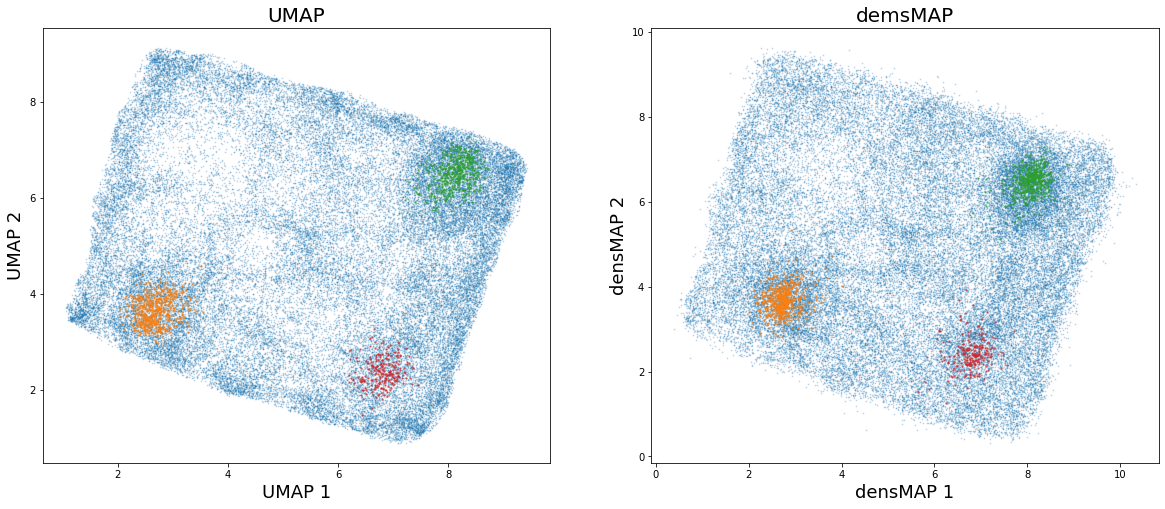

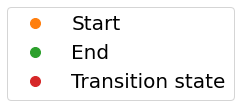

In [8]:
umap_emb = np.load(f'{workdir}/umap_emb.npy')
dens_emb = np.load(f'{workdir}/dens_emb.npy')
labels = [state1, state2, transition_state]
state_legend = ["Start", "End", "Transition state"]
state_colors = ['tab:orange', 'tab:green', 'tab:red']


fig, axs = plt.subplots(1, 2, figsize=(20, 8))
# UMAP
axs[0].scatter(umap_emb[:, 0], umap_emb[:, 1], s=0.5, alpha=0.25)  
for i, state in enumerate(labels):
    axs[0].scatter(umap_emb[state][:, 0], umap_emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1)
axs[0].set_title('UMAP', fontsize=20)
axs[0].set_xlabel('UMAP 1', fontsize=18)
axs[0].set_ylabel('UMAP 2', fontsize=18)
# densMAP
axs[1].scatter(dens_emb[:, 0], dens_emb[:, 1], s=0.5, alpha=0.25)  
for i, state in enumerate(labels):
    axs[1].scatter(dens_emb[state][:, 0], dens_emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1)  
axs[1].set_title('demsMAP', fontsize=20)
axs[1].set_xlabel('densMAP 1', fontsize=18)
axs[1].set_ylabel('densMAP 2', fontsize=18)
plt.show()

# legend plot
fig_legend = plt.figure(figsize=(2, 1))  
axi = fig_legend.add_subplot(111)
axi.axis('off')
lines_states = [plt.Line2D([0], [0], color=c, marker='o', linestyle='', markersize=10) for c in state_colors]
fig_legend.legend(lines_states, state_legend, fontsize=20, loc='center')
plt.show()

<ipython-input-2-a838f5ed2030>:17: RuntimeWarning: divide by zero encountered in log
  E = -np.log(grids/occmax)


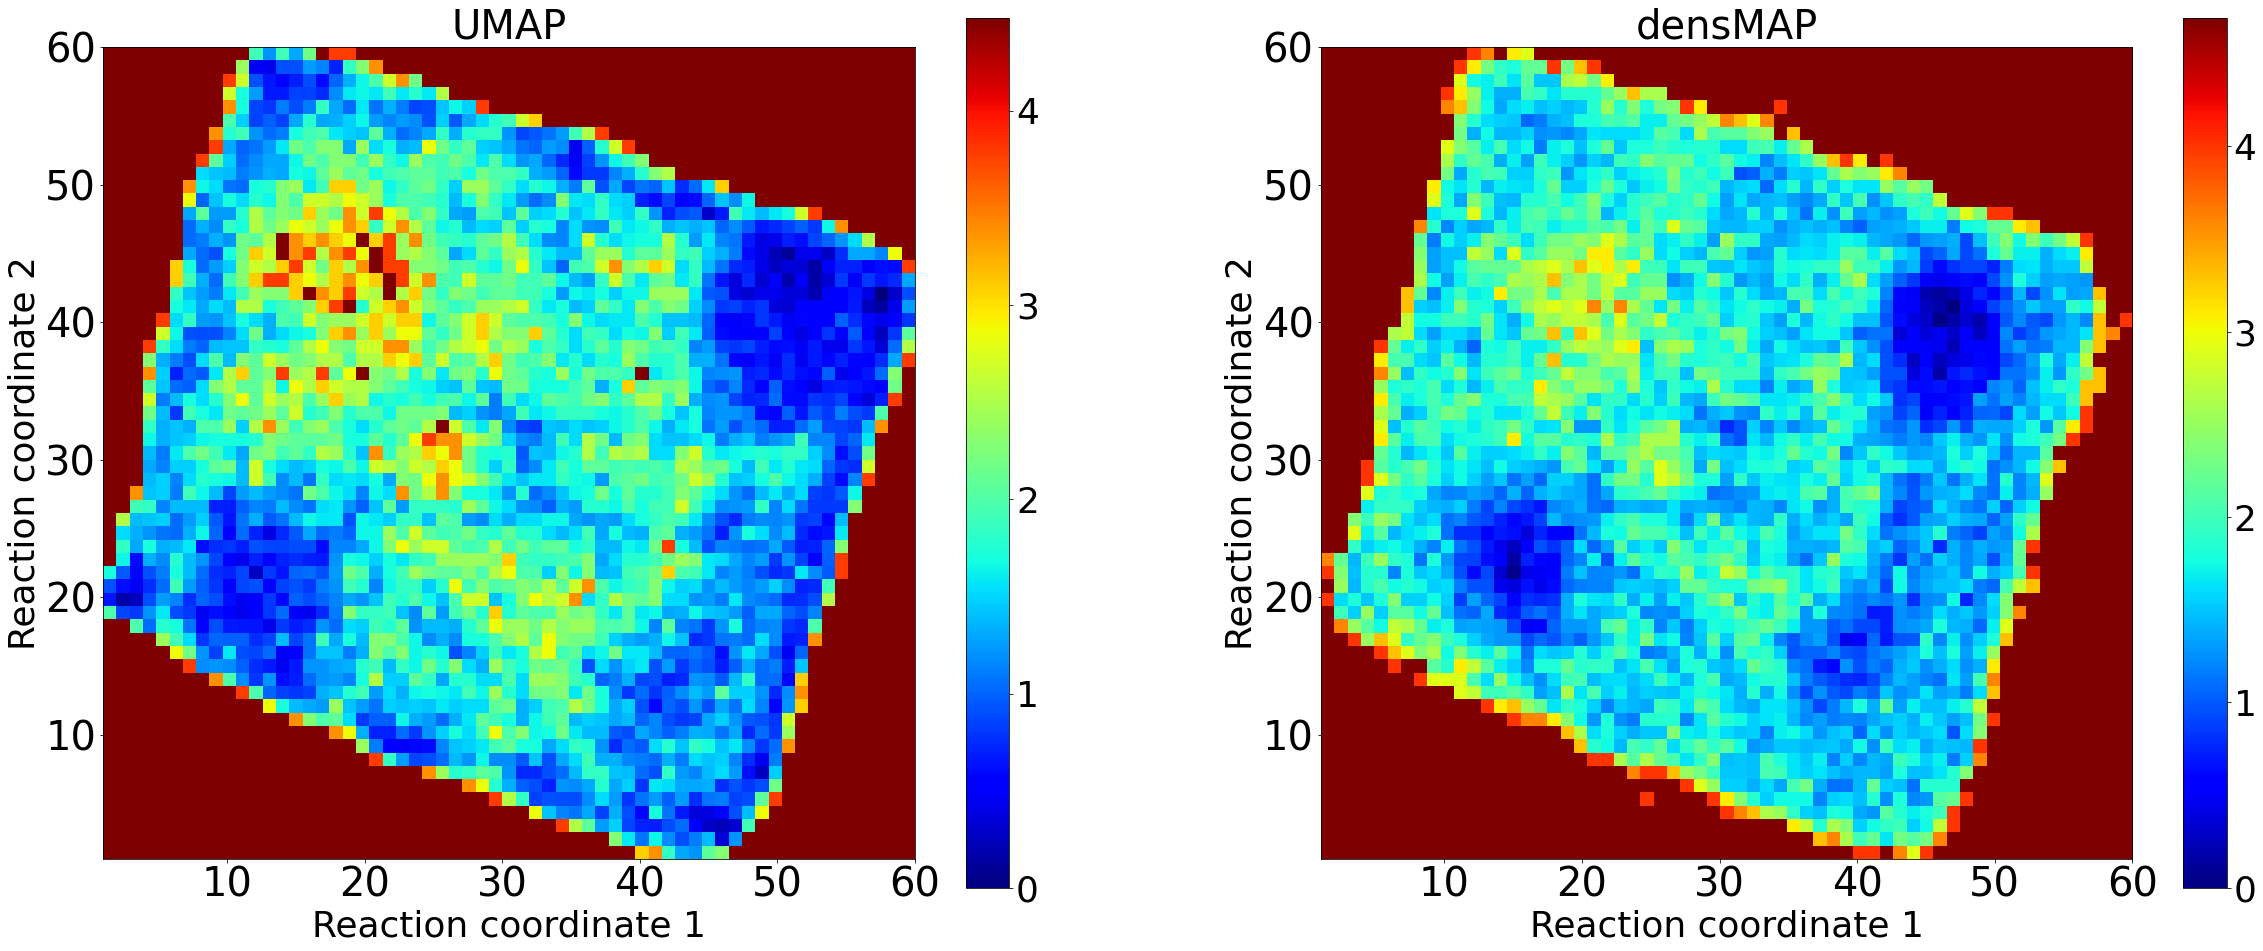

In [22]:
umap_eng = free_energy(umap_emb, n_states=60)
dens_eng = free_energy(dens_emb, n_states=60)

fig, axs = plt.subplots(1, 2, figsize=(40, 16))
# UMAP
im0 = axs[0].imshow(umap_eng, origin='lower', extent=[1,60,1,60], cmap='jet')
cbar = fig.colorbar(im0, ax=axs[0])
cbar.ax.set_yticks([0,1,2,3,4])
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4'], fontsize=36)
axs[0].tick_params(axis='both', which='major', labelsize=40)
axs[0].set_title('UMAP', fontsize=40)
axs[0].set_xlabel('Reaction coordinate 1', fontsize=36)
axs[0].set_ylabel('Reaction coordinate 2', fontsize=36)
# densMAP
im1 = axs[1].imshow(dens_eng, origin='lower', extent=[1,60,1,60], cmap='jet')
cbar = fig.colorbar(im1, ax=axs[1])
cbar.ax.set_yticks([0,1,2,3,4])
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4'], fontsize=36)
axs[1].tick_params(axis='both', which='major', labelsize=40)
axs[1].set_title('densMAP', fontsize=40)
axs[1].set_xlabel('Reaction coordinate 1', fontsize=36)
axs[1].set_ylabel('Reaction coordinate 2', fontsize=36)

plt.show()


# Comparsion
We wanted to search as closely as possible to the ground truth transition sequence, especially when providing the center of the transition state as input.  However, the energy landscape created by UMAP shifts the path more towards the edges, which is much worse than the case when we use densMAP.

In [10]:
np.savetxt('/home/danlin/POLARIS/data_input/hsp90_umap.txt', umap_eng)
print("UMAP")
pol_input_umap = points_for_polaris(umap_emb, n_states=60, list_idx=[center1, transition, center2])
print(f'Start:{pol_input_umap[0,:]}, Transition:{pol_input_umap[1,:]}, End:{pol_input_umap[2,:]}')
print("densMAP")
pol_input_densmap = points_for_polaris(dens_emb, n_states=60, list_idx=[center1, transition, center2])
print(f'Start:{pol_input_densmap[0,:]}, Transition:{pol_input_densmap[1,:]}, End:{pol_input_densmap[2,:]}')

UMAP
Start:[10 19], Transition:[40  9], End:[51 43]
densMAP
Start:[14 21], Transition:[37 13], End:[46 40]


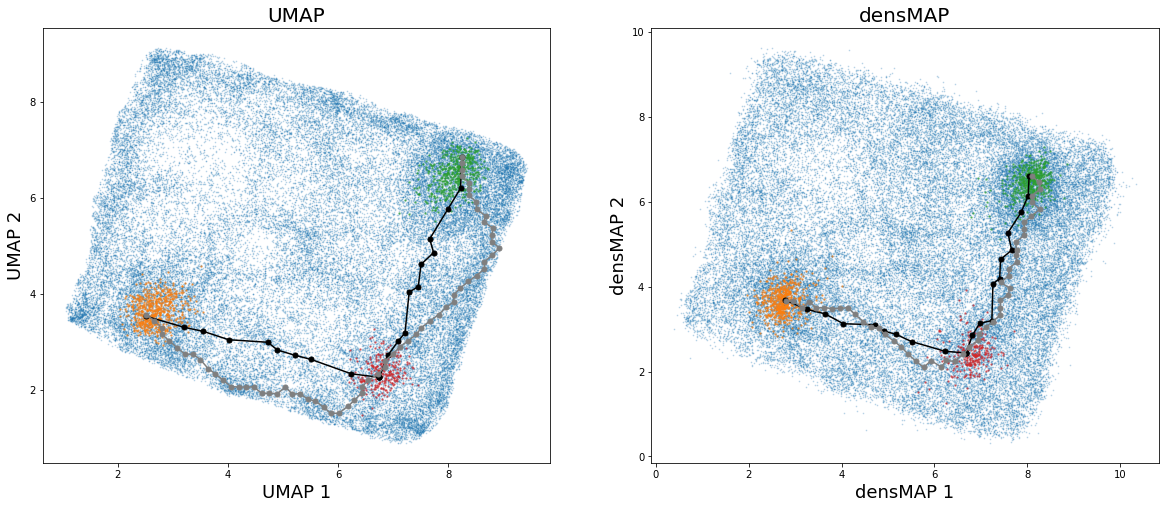

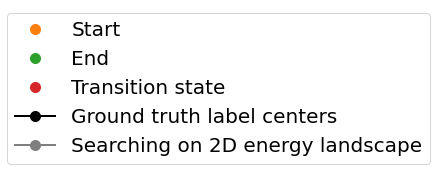

In [11]:
umap_result = np.loadtxt(f'{workdir}/polaris_umap/polaris_umap.txt', skiprows=9, usecols=(0, 1)) 
umap_result = convert_polaris_result(emb=umap_emb, path=umap_result).astype(int)
densmap_result = np.loadtxt(f'{workdir}/polaris_densmap/polaris_densmap.txt', skiprows=9, usecols=(0, 1)) #only keep x and y coodrinate
densmap_result = convert_polaris_result(emb=dens_emb, path=densmap_result).astype(int)

state_legend = ["Start", "End", "Transition state"]
state_colors = ['tab:orange', 'tab:green', 'tab:red']
path_legend = ["Ground truth label centers", 
            "Searching on 2D energy landscape"]
path_colors= ['k', 'tab:gray']


fig, axs = plt.subplots(1, 2, figsize=(20, 8))
# UMAP
axs[0].scatter(umap_emb[:, 0], umap_emb[:, 1], s=0.5, alpha=0.25)  
for i, state in enumerate([state1, state2, transition_state]):
    axs[0].scatter(umap_emb[state][:, 0], umap_emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1)
for i, path in enumerate([truth_path, umap_result]):
    axs[0].plot(
        umap_emb[path][:, 0], umap_emb[path][:, 1], '-o',
        markersize=5, c=path_colors[i], zorder=2
    ) #paths
axs[0].set_title('UMAP', fontsize=20)
axs[0].set_xlabel('UMAP 1', fontsize=18)
axs[0].set_ylabel('UMAP 2', fontsize=18)
# densMAP
axs[1].scatter(dens_emb[:, 0], dens_emb[:, 1], s=0.5, alpha=0.25)  
for i, state in enumerate([state1, state2, transition_state]):
    axs[1].scatter(dens_emb[state][:, 0], dens_emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1)
for i, path in enumerate([truth_path, densmap_result]):
    axs[1].plot(
        dens_emb[path][:, 0], dens_emb[path][:, 1], '-o',
        markersize=5, c=path_colors[i], zorder=2
    ) #paths
axs[1].set_title('densMAP', fontsize=20)
axs[1].set_xlabel('densMAP 1', fontsize=18)
axs[1].set_ylabel('densMAP 2', fontsize=18)
plt.show()

# legend plot
fig_legend_combined = plt.figure(figsize=(5, 3))  
axi = fig_legend_combined.add_subplot(111)
axi.axis('off')
lines_states = [plt.Line2D([0], [0], color=c, marker='o', linestyle='', markersize=10) for c in state_colors]
lines_paths = [plt.Line2D([0], [0], color=c, linewidth=2, marker='o', markersize=10) for c in path_colors] 
combined_lines = lines_states + lines_paths
combined_labels = state_legend + path_legend
fig_legend_combined.legend(combined_lines, combined_labels, fontsize=20, loc='center')
plt.show()

In [12]:
def closest_to_transition(z, path, transition_idx):
    '''
    Find the point in the path which is closest to the transtion state center
    '''
    nearest_point = None
    nearest_distance = float('inf')
    for indx, points in enumerate(z[path]):
        d = distance.euclidean(z[transition_idx], points)
        if d < nearest_distance:
            nearest_point = indx
            nearest_distance = d
    return path[nearest_point], nearest_distance

def ave_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)/(len(truth)-2)
    
def sum_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)

def hausdorff_distance(set1, set2):
  # Initialize maximum distance to 0
  max_distance_1 = 0
  
  # Iterate through points in set1
  for point1 in set1:
    # Find nearest point in set2
    nearest_point = None
    nearest_distance = float('inf')
    for point2 in set2:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point2
        nearest_distance = d
    # Update maximum distance if necessary
    max_distance_1 = max(max_distance_1, nearest_distance)
  
  max_distance_2 = 0

  for point2 in set2:
    nearest_point = None
    nearest_distance = float('inf')

    for point1 in set1:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point1
        nearest_distance = d
    
    max_distance_2 = max(max_distance_2, nearest_distance)

  max_distance = max(max_distance_1, max_distance_2)
  return max_distance

In [13]:
print("UMAP:", ave_distance(z, truth_path, umap_result))
print("DensMAP:", ave_distance(z, truth_path, densmap_result))

UMAP: 1.238785485426585
DensMAP: 0.8792220226355961


In [15]:
print("UMAP:", hausdorff_distance(z[truth_path], z[umap_result]))
print("DensMAP:", hausdorff_distance(z[truth_path], z[densmap_result]))

UMAP: 3.6607346534729004
DensMAP: 2.920093059539795
